In [2]:
import cv2
import numpy as np
import os

def load_images_from_folder(folder):
    """Belirtilen klasörden tüm görüntüleri yükleyin ve SIFT özelliklerini çıkarın."""
    images = []
    sift = cv2.SIFT_create()
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            kp, des = sift.detectAndCompute(img, None)
            images.append((filename, des))
    return images


def match_features(des1, des2):
    """İki özellik seti arasındaki eşleşmeleri bulun."""
    # Boş tanımlayıcı kontrolleri
    if des1 is None or des2 is None:
        return 0
    
    # Tanımlayıcıları float32'ye dönüştür
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for match in matches:
        # Her eşleşme listesinin uzunluğunu kontrol et
        if len(match) == 2:
            m, n = match
            if m.distance < 0.75*n.distance:
                good.append(m)
    return len(good)

def classify_image(test_img_path, training_features):
    """Test görüntüsünden SIFT özelliklerini çıkar ve sınıflandır."""
    sift = cv2.SIFT_create()
    img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Image not found or unsupported format"
    
    kp, des_test = sift.detectAndCompute(img, None)
    # Test tanımlayıcısının boş olup olmadığını kontrol et
    if des_test is None:
        return "No features found in test image"
    
    best_match = {'class': None, 'matches': 0}
    for class_name, features in training_features.items():
        total_matches = 0
        for _, des_train in features:
            # Eğitim seti tanımlayıcısının boş olup olmadığını kontrol et
            if des_train is not None:
                matches = match_features(des_test, des_train)
                total_matches += matches
        if total_matches > best_match['matches']:
            best_match = {'class': class_name, 'matches': total_matches}

    return best_match['class']


# Eğitim setini yükleyin
training_features = {}
for class_folder in os.listdir(r'C:\Users\halil\Downloads\GTSRB - Kopya\crop_dataset\crop_dataset'):
    folder_path = os.path.join(r'C:\Users\halil\Downloads\GTSRB - Kopya\crop_dataset\crop_dataset', class_folder)
    training_features[class_folder] = load_images_from_folder(folder_path)

# Test görüntüsünü sınıflandırın
test_img_path = r'C:\Users\halil\Downloads\GTSRB - Kopya\test_data\test_data\11910.jpg'
predicted_class = classify_image(test_img_path, training_features)
print(f"Predicted class: {predicted_class}")


Predicted class: 00013



Recall:
 [0.69166667 0.83866667 0.11333333 0.45757576 0.23968254 0.54666667
 0.25333333 0.5125     0.77727273 0.82380952 0.57681159 0.94861111
 0.69722222 0.51282051 0.88333333 0.24615385 0.71884058 0.
 0.         0.        ]

Precision:
 [0.58382181 0.51472995 0.73913043 0.94080997 0.24006359 0.86925795
 0.94214876 0.984      0.65184244 0.99711816 0.87280702 0.57979626
 0.93656716 0.96618357 0.89451477 0.54237288 0.62155388 0.
 0.         0.        ]




Accuracy: 60.10%




Micro Average Recall: 0.60
Micro Average Precision: 0.60



Macro Average Recall: 0.49
Macro Average Precision: 0.64



Overall Accuracy: 0.60
F1 Score: 0.60


C:\Users\halil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\halil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


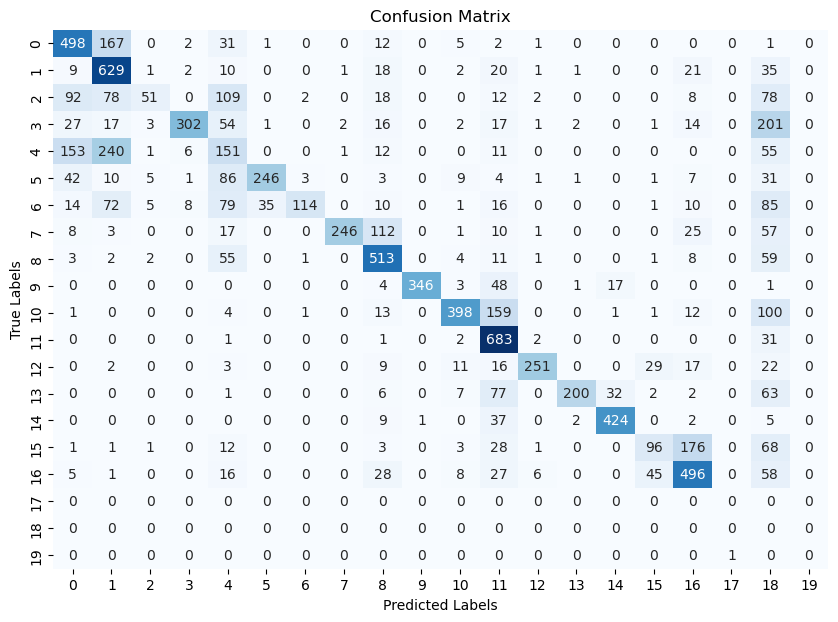

In [10]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# CSV dosyasını oku ve tek bir sütundaki veriyi iki sütuna ayır
test_labels_path = r'C:\Users\halil\Downloads\GTSRB - Kopya\fixed_test_label.csv'
test_labels_df = pd.read_csv(test_labels_path, sep=',', names=['Image', 'Label'])

# Test resimlerinin bulunduğu klasör yolu
test_images_folder = r'C:\Users\halil\Downloads\GTSRB - Kopya\test_data\test_data'

# Doğru tahminlerin sayısını sakla
correct_predictions = 0

# Toplam resim sayısı
total_images = len(test_labels_df)

# Actual and predicted classes
actual_classes = []
predicted_classes = []

# Test resimleri üzerinde döngü
for index, row in test_labels_df.iterrows():
    test_img_filename = row['Image']
    test_img_path = os.path.join(test_images_folder, test_img_filename)
    actual_class = str(row['Label']).zfill(5)  # Gerçek sınıf etiketini string olarak al
    actual_classes.append(actual_class)

    # Resim için sınıf tahmini yap
    predicted_class = classify_image(test_img_path, training_features)
    predicted_classes.append(predicted_class)
    
    # Tahmin edilen sınıf ile gerçek sınıfı karşılaştır
    if str(predicted_class) == actual_class:  # predicted_class'ı ve actual_class'ı aynı türde karşılaştır
        correct_predictions += 1


actual_classes = np.array(actual_classes)
predicted_classes = np.array(predicted_classes)

# Metrikleri Hesaplama
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes, average=None, zero_division=0)
precision = precision_score(actual_classes, predicted_classes, average=None, zero_division=0)
accuracy = accuracy_score(actual_classes, predicted_classes)

# Sonuçları yazdır
print(f"\nRecall:\n {recall}")
print(f"\nPrecision:\n {precision}")
print(f"\n\n\n\nAccuracy: {accuracy:.2%}")

# Micro average ile genel recall, precision ve accuracy hesaplama
recall_micro = recall_score(actual_classes, predicted_classes, average='micro')
precision_micro = precision_score(actual_classes, predicted_classes, average='micro')
accuracy_micro = accuracy_score(actual_classes, predicted_classes)

# Macro average ile genel recall ve precision hesaplama
recall_macro = recall_score(actual_classes, predicted_classes, average='macro')
precision_macro = precision_score(actual_classes, predicted_classes, average='macro')
f1_score = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)

print(f"\n\n\n\nMicro Average Recall: {recall_micro:.2f}")
print(f"Micro Average Precision: {precision_micro:.2f}")
print(f"\n\n\nMacro Average Recall: {recall_macro:.2f}")
print(f"Macro Average Precision: {precision_macro:.2f}")
print(f"\n\n\nOverall Accuracy: {accuracy_micro:.2f}")
print(f"F1 Score: {f1_score:.2f}")


import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

